# Part 1 Working with RDD 

# 1.1

In [33]:
# 1 

# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment_1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')


In [34]:
# 2

# import trip csv into single RDD

# create single RDD
trip_rdd = sc.textFile('data/trip.csv')

In [35]:
# 3

# import passenger csv into single RDD

# create single RDD
passenger_rdd = sc.textFile('data/passenger.csv')

In [36]:
# 4 
# remove the header row
header = trip_rdd.first()
trip_rdd_data = trip_rdd.filter(lambda row: row != header)

# show 5 records 
trip_rdd_data.take(5)

['a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36',
 'a84c2d10,3034e6fe,e1bd0c8d,43006,7/1/2019 8:56:28 PM,7/1/2019 9:22:09 PM,0,9.36,6.91',
 'a84c3e75,93fb6802,75e6d450,43050,8/20/2019 9:30:46 PM,8/20/2019 9:46:48 PM,0,4.39,3.48',
 'a84c3f6f,25fc9273,5ba48e89,43020,9/8/2019 2:42:41 AM,9/8/2019 2:59:56 AM,0,2.04,1.54',
 'a84c5ce2,484c4d0c,fdb2ef59,43006,6/10/2019 9:29:18 AM,6/10/2019 9:55:36 AM,0,7.37,5.83']

In [37]:
# remove the header row
header1 = passenger_rdd.first()
passenger_rdd_data = passenger_rdd.filter(lambda row: row != header1)

# show 5 records 
passenger_rdd_data.take(5)

['00000fab,5/11/2019 8:23:54 PM',
 '0000149d,12/24/2018 9:21:33 PM',
 '00002b66,9/20/2018 9:08:24 PM',
 '00002bc7,7/28/2019 11:27:56 AM',
 '0000332e,2/21/2019 11:34:24 PM']

# 1.2

In [38]:
# 1
print('Trip default partitions: ',trip_rdd.getNumPartitions())
print('Passenger default partitions: ',passenger_rdd.getNumPartitions())

Trip default partitions:  6
Passenger default partitions:  2


By Default, when the number of partition is not specified, Spark creates one Partition for each block of the file (For HDFS)
Default block size for HDFS block is 64 MB (Hadoop Version 1) / 128 MB (Hadoop Version 2).

In [39]:
# 2 
from datetime import datetime
# a
mapValues_passenger_rdd = passenger_rdd_data

# create key value pair rdd
# Implement function with logic to be applied to the RDDs
def parseRecord(line):
    array_line = line.split(',')
    sign = ""
    if array_line[1] != "":
        date = array_line[1].split(' ')
        date_list = date[0].split('/')
        year = int(date_list[2])
        sign = "Not In 2019"
        if year == 2019:
            sign = "In 2019"
    # Return a tuple with the key as first element and the remaining as the second element
    return (sign, line)

mapValues_passenger_rdd_1 = mapValues_passenger_rdd.map(parseRecord)

# the first_call_time row is in 1

# show 5 values
mapValues_passenger_rdd_1.take(5)

[('In 2019', '00000fab,5/11/2019 8:23:54 PM'),
 ('Not In 2019', '0000149d,12/24/2018 9:21:33 PM'),
 ('Not In 2019', '00002b66,9/20/2018 9:08:24 PM'),
 ('In 2019', '00002bc7,7/28/2019 11:27:56 AM'),
 ('In 2019', '0000332e,2/21/2019 11:34:24 PM')]

In [40]:
# b 
no_of_partitions = 2

#Define a range of values by key to distribute across partitions

def range_function(key):
     if key == "In 2019":
         return 0
     else:
         return 1



In [41]:
# partition
#result = mapValues_passenger_rdd_1.map(lambda elem: list(elem)).collect()
#rdd = sc.parallelize(result, no_of_partitions)
rdd = mapValues_passenger_rdd_1.partitionBy(no_of_partitions, range_function)

In [42]:
partitions = rdd.glom().collect()
for index, partition in enumerate(partitions):
    # show partition if it is not empty
    if len(partition) > 0:
        print(f"Partition {index}: {len(partition)} records")

Partition 0: 556856 records
Partition 1: 678926 records


# 1.3

In [43]:
# 1 

# surge_rate column
surge_count = trip_rdd_data.map(lambda line : line.split(',')[6]).count()
print("There are " + str(surge_count) + " records in surge rate before filter")
trip_filtered = trip_rdd_data.filter(lambda line : line.split(',')[6] != '')
trip_filtered_surge_count = trip_filtered.map(lambda line : line.split(',')[6]).count()
print("There are " + str(trip_filtered_surge_count) + " records in surge rate after filter")

There are 2318357 records in surge rate before filter


There are 2318351 records in surge rate after filter


In [44]:
# trip_distance column
trip_distance = trip_filtered.map(lambda line : line.split(',')[7]).count()
print("There are " + str(trip_distance) + " records in trip_distance before filter")
trip_filtered = trip_filtered.filter(lambda line : line.split(',')[7] != '')
trip_filtered_distance_count = trip_filtered.map(lambda line : line.split(',')[7]).count()
print("There are " + str(trip_filtered_distance_count) + " records in trip_distance after filter")

There are 2318351 records in trip_distance before filter


There are 2295112 records in trip_distance after filter


In [45]:
# 2
# filter the data make it key value pair
def parseRecord2(line):
    array_line = line.split(',')
    return (int(array_line[3]), float(array_line[6]))
city_surge = trip_filtered.map(parseRecord2)
countsByKey = sc.broadcast(city_surge.countByKey())
avg_city_surge = city_surge.reduceByKey(lambda a,b: a+b)
avg = avg_city_surge.map(lambda x: (x[0], x[1]/countsByKey.value[x[0]]))
print(avg.collect())

[(43050, 0.05545981386673684), (43020, 0.03600285427063479), (43278, 0.022864212716075583), (43116, 0.059504653033246084), (43179, 0.07075066034400256), (43006, 0.03495577782547935)]


In [46]:
#3 

# filter out negative trip distance 
trip_filtered = trip_filtered.filter(lambda line : float(line.split(',')[7]) >= 0)
# filter the data make it key value pair
def parseRecord3(line):
    array_line = line.split(',')
    return (array_line[1], float(array_line[7]))
driver_distance = trip_filtered.map(parseRecord3)

# find max distance
driver_max = driver_distance.max(lambda x: x[1])
print(driver_max)
print("Driver " + driver_max[0] +" has max trip distance of " + str(driver_max[1]))

# print out other trips 
max_trips = driver_distance.filter(lambda x: x[0] == driver_max[0]).collect()
print("Driver " + driver_max[0] + "'s other trips")
print(max_trips)

# find min distance
driver_min = driver_distance.min(lambda x: x[1])
print(driver_min)
print("Driver " + driver_min[0] +" has min trip distance of " + str(driver_min[1]))
      
# print out other trips 
min_trips = driver_distance.filter(lambda x: x[0] == driver_min[0]).collect()
print("Driver " + driver_min[0] + "'s other trips")
print(min_trips)

('704642b5', 296.1)
Driver 704642b5 has max trip distance of 296.1


Driver 704642b5's other trips
[('704642b5', 3.21), ('704642b5', 11.09), ('704642b5', 2.61), ('704642b5', 11.7), ('704642b5', 4.65), ('704642b5', 10.42), ('704642b5', 16.7), ('704642b5', 0.43), ('704642b5', 296.1), ('704642b5', 8.1)]


('9019790c', 0.0)
Driver 9019790c has min trip distance of 0.0


Driver 9019790c's other trips
[('9019790c', 0.0), ('9019790c', 3.73), ('9019790c', 15.39)]


# Part 2 Working with DataFrames

# 2.1

In [47]:
# 1 

# Load datas
df_trip = spark.read.csv('data/trip.csv',header=True, inferSchema=True)
df_passenger = spark.read.csv('data/passenger.csv',header=True, inferSchema=True)
df_city = spark.read.csv('data/city.csv',header=True, inferSchema=True)

df_trip.printSchema()
df_passenger.printSchema()
df_city.printSchema()

root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- call_time: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- surge_rate: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_fare: double (nullable = true)

root
 |-- id: string (nullable = true)
 |-- first_call_time: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)



# 2.2

In [48]:
#1 
df_city = df_city.withColumnRenamed('id', 'city_id')
df_city.show()

+-------+------------+
|city_id|        name|
+-------+------------+
|  42868|      Mordor|
|  42948|      Erebor|
|  43006|Minas Tirith|
|  43020|    Isengard|
|  43050|      Gondor|
|  43094|       Moria|
|  43116|       Rohan|
|  43179|   Rivendell|
|  43244| Minas Ithis|
|  43278|   The Shire|
+-------+------------+



In [49]:
#2 
df_joined = df_city.join(df_trip,df_city.city_id==df_trip.city_id,how='inner')

In [50]:
#3
df_joined_3 = df_joined.filter(df_joined.trip_distance > 0)
df_joined_3 = df_joined_3.filter(df_joined.trip_fare > 0)
df_joined_3.show(5)

+-------+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+
|city_id|        name|      id|driver_id|passenger_id|city_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+-------+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+
|  43006|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|  43006|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|  43006|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d|  43006| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|  43050|      Gondor|a84c3e75| 93fb6802|    75e6d450|  43050|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|  43020|    Isengard|a84c3f6f| 25fc9273|    5ba48e89|  43020| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|  43006|Minas Tirit

In [51]:
#4
from pyspark.sql.functions import *
df_joined_4 = df_joined_3.sort(df_joined_3.trip_distance.desc())
df_joined_4_s = df_joined_4.select(col('id'),col('driver_id'),col('passenger_id'),col('trip_distance'))
df_joined_4_s.show(5)

+--------+---------+------------+-------------+
|      id|driver_id|passenger_id|trip_distance|
+--------+---------+------------+-------------+
|7f4a1ec5| 704642b5|    771e01b2|        296.1|
|30bb5f34| 7119b481|    d5e5e5d8|       261.71|
|ac1861e1| ceccad76|    2a2f3fc5|       244.82|
|4525a2bf| bdb22ca4|    b7f9f488|       236.14|
|b60c4614| 70b9733e|    09ec3959|       235.42|
+--------+---------+------------+-------------+
only showing top 5 rows



# 2.3

In [52]:
#1 

#1. The function is defined

def On_holiday(line):
    holiday = ['1/1/2019', '3/5/2019', '4/19/2019', '4/21/2019', '5/1/2019', '6/20/2019',\
           '9/7/2019', '10/12/2019', '11/2/2019', '11/15/2019', '12/25/2019']
    array_line = line.split(' ')
    check = False
    if array_line[0] in holiday:
        check = True
    return check
#2. Calling the UDF with DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# NOTE: it seems that calls to udf() must be after SparkContext() is called
udf_On_holiday = udf(On_holiday, BooleanType())
df_changed = df_joined.withColumn("On_holiday", udf_On_holiday("call_time"))
df_changed.tail(5)

[Row(city_id=43006, name='Minas Tirith', id='a84b949e', driver_id='a454c95d', passenger_id='906eee37', city_id=43006, call_time='7/6/2019 6:32:54 AM', finish_time='7/6/2019 6:53:35 AM', surge_rate=0.0, trip_distance=4.72, trip_fare=3.18, On_holiday=False),
 Row(city_id=43050, name='Gondor', id='a84bc1e0', driver_id='1a154fe4', passenger_id='313bd7fe', city_id=43050, call_time='7/22/2019 5:58:25 PM', finish_time='7/22/2019 6:54:49 PM', surge_rate=0.0, trip_distance=20.2, trip_fare=10.69, On_holiday=False),
 Row(city_id=43050, name='Gondor', id='a84bcd75', driver_id='9e8e5eb2', passenger_id='47253b43', city_id=43050, call_time='9/7/2019 6:24:18 PM', finish_time='9/7/2019 6:47:46 PM', surge_rate=0.0, trip_distance=8.78, trip_fare=7.41, On_holiday=True),
 Row(city_id=43006, name='Minas Tirith', id='a84bde9a', driver_id='e609e0a3', passenger_id='b731ab38', city_id=43006, call_time='7/2/2019 6:24:59 PM', finish_time='7/2/2019 6:38:58 PM', surge_rate=0.0, trip_distance=3.4, trip_fare=1.84, On

In [54]:
#2 use dataframe
df_changed_2 = df_changed.groupBy("name","On_holiday").agg({"trip_fare":"avg"})
df_changed_2 = df_changed_2.sort("name","On_holiday")
df_changed_2.show(12)

+------------+----------+------------------+
|        name|On_holiday|    avg(trip_fare)|
+------------+----------+------------------+
|      Gondor|     false|  5.13122212820313|
|      Gondor|      true|5.4218031555221575|
|    Isengard|     false| 5.550994994344451|
|    Isengard|      true| 5.690277565084232|
|Minas Tirith|     false| 4.969949667768408|
|Minas Tirith|      true|  5.22092199619494|
|   Rivendell|     false| 5.669180818214374|
|   Rivendell|      true| 5.851725862931469|
|       Rohan|     false| 5.276064985963267|
|       Rohan|      true| 5.455164385996093|
|   The Shire|     false| 4.995571570029671|
|   The Shire|      true| 5.189087501615612|
+------------+----------+------------------+



In [55]:
# use sql
# Create Views from Dataframes
df_changed.createOrReplaceTempView("sql_changed")
#### Aggregate the dataset by 'Year' and count the total number of athletes using SQL
sql_changed = spark.sql('''
  SELECT name,On_holiday,AVG(trip_fare)
  FROM sql_changed
  GROUP BY name,On_holiday
  ORDER BY name,On_holiday
''')
sql_changed.show(12)

+------------+----------+------------------+
|        name|On_holiday|    avg(trip_fare)|
+------------+----------+------------------+
|      Gondor|     false|  5.13122212820313|
|      Gondor|      true|5.4218031555221575|
|    Isengard|     false| 5.550994994344451|
|    Isengard|      true| 5.690277565084232|
|Minas Tirith|     false| 4.969949667768408|
|Minas Tirith|      true|  5.22092199619494|
|   Rivendell|     false| 5.669180818214374|
|   Rivendell|      true| 5.851725862931469|
|       Rohan|     false| 5.276064985963267|
|       Rohan|      true| 5.455164385996093|
|   The Shire|     false| 4.995571570029671|
|   The Shire|      true| 5.189087501615612|
+------------+----------+------------------+



In [56]:
#3 
import datetime
def Weekday1(line):
    array_line = line.split(' ')
    return array_line[0]
# NOTE: it seems that calls to udf() must be after SparkContext() is called
udf_Weekday1 = udf(Weekday1, StringType())
df_weekday = df_joined.withColumn("date", udf_Weekday1("call_time"))
# convert using to_date function
df_col = df_weekday.select("*",to_date(col("date"),"M/d/yyyy").alias("dateday"))
df_col = df_col.drop("date")
# define date function
def Weekday2(d):
    day = d.weekday() 
    weekday = ['MON','TUE','WED','THU','FRI','SAT','SUN']
    return weekday[day]
udf_Weekday2 = udf(Weekday2, StringType())
df_col = df_col.withColumn("weekday", udf_Weekday2("dateday"))
df_col = df_col.drop("dateday")
df_col.show(5)

+-------+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+-------+
|city_id|        name|      id|driver_id|passenger_id|city_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|weekday|
+-------+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+-------+
|  43006|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|  43006|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|    SUN|
|  43006|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d|  43006| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|    MON|
|  43050|      Gondor|a84c3e75| 93fb6802|    75e6d450|  43050|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|    TUE|
|  43020|    Isengard|a84c3f6f| 25fc9273|    5ba48e89|  43020| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0

In [57]:
# 4 
# use sql
# Create Views from Dataframes
df_col.createOrReplaceTempView("sql_4")
#### Aggregate the dataset by 'Year' and count the total number of athletes using SQL
sql_4 = spark.sql('''
  SELECT name,weekday,COUNT(name)
  FROM sql_4
  GROUP BY name,weekday
  ORDER BY name,weekday
''')
sql_4 = sql_4.withColumnRenamed('count(name)', 'Count')
sql_4.createOrReplaceTempView("sql_4_1")
sql_4_1 = spark.sql('''
  SELECT name,SUM(Count)
  FROM sql_4_1
  GROUP BY name
  ORDER BY name
''')
sql_4 = sql_4.withColumnRenamed('name', 'city')
sql_joined = sql_4.join(sql_4_1,sql_4.city==sql_4_1.name,how='inner')
def Percentage(num1,num2):
    result = num1/num2
    return result*100
# NOTE: it seems that calls to udf() must be after SparkContext() is called
udf_4 = udf(Percentage, DoubleType())
sql_joined = sql_joined.withColumn("Percentage", udf_4('Count','sum(Count)'))
sql_joined = sql_joined.drop('name','sum(Count)')
sql_joined = sql_joined.sort("city","weekday")
sql_joined.show(8)

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 642, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 595, in read_int
    raise EOFError
EOFError


+--------+-------+-----+------------------+
|    city|weekday|Count|        Percentage|
+--------+-------+-----+------------------+
|  Gondor|    FRI|45623|14.324377784545634|
|  Gondor|    MON|45502|14.286387084417848|
|  Gondor|    SAT|51117|16.049343953984156|
|  Gondor|    SUN|52755| 16.56363128298676|
|  Gondor|    THU|42607|13.377436035905921|
|  Gondor|    TUE|39995| 12.55733926951105|
|  Gondor|    WED|40900| 12.84148458864863|
|Isengard|    FRI|49305|14.602485428612047|
+--------+-------+-----+------------------+
only showing top 8 rows



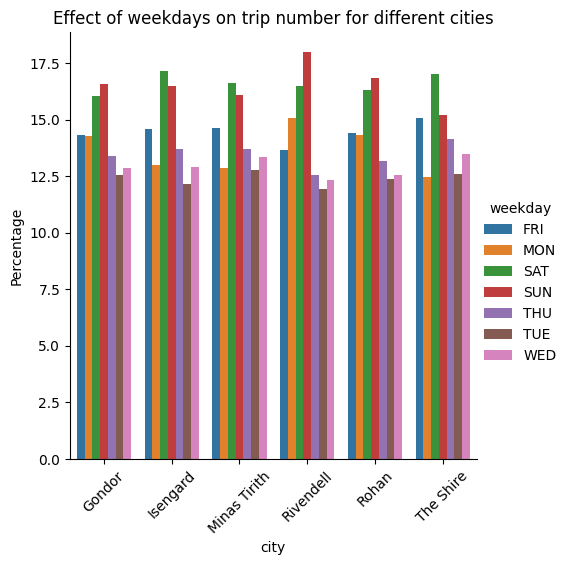

In [58]:
#5
#create bar plot of each city and trip number
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sql_graph = sql_joined.filter(sql_joined.weekday == 'FRI')
bar = sql_joined.toPandas()
sns.catplot(x = 'city', y='Percentage',hue = 'weekday',data=bar, kind='bar')
plt.title('Effect of weekdays on trip number for different cities')
plt.xticks(rotation = 45)
plt.show()

# Part 3

# RDD

In [64]:
%%time
city_rdd = sc.textFile('data/city.csv')
# remove the header row
header_city = city_rdd.first()
city_rdd_data = city_rdd.filter(lambda row: row != header_city)

# join on city id 
# show 5 records 
# format rdd
def parseCity(line):
    array_line = line.split(',')
    return (array_line[0], array_line[1])

city_rdd_datas = city_rdd.map(parseCity)

def parseTrip(line):
    array_line = line.split(',')
    return (array_line[3], array_line[0] + ',' + array_line[4])

trip_rdd_datas = trip_rdd_data.map(parseTrip)
# join datas
rdd_join = city_rdd_datas.join(trip_rdd_datas)
rdd_join = rdd_join.filter(lambda row: row[1][0] == 'Minas Tirith')
#rdd_join = rdd_join.toDF().select('_2')
rdd_join.flatMap(lambda row: row[1]).take(20)

CPU times: user 11.1 ms, sys: 9.84 ms, total: 20.9 ms
Wall time: 4.8 s


['Minas Tirith',
 'a84c0db2,9/8/2019 10:01:28 PM',
 'Minas Tirith',
 'a84c2d10,7/1/2019 8:56:28 PM',
 'Minas Tirith',
 'a84c5ce2,6/10/2019 9:29:18 AM',
 'Minas Tirith',
 'a84ceb22,6/30/2019 3:09:18 AM',
 'Minas Tirith',
 'a84d29a0,8/11/2019 9:49:49 PM',
 'Minas Tirith',
 'a84d31ee,7/7/2019 11:53:51 PM',
 'Minas Tirith',
 'a84d8d16,6/24/2019 7:25:16 AM',
 'Minas Tirith',
 'a84dbd8a,7/1/2019 9:56:52 PM',
 'Minas Tirith',
 'a84dc20a,6/13/2019 2:42:58 AM',
 'Minas Tirith',
 'a84dfcb7,7/27/2019 6:19:44 PM']

# DataFrame

In [60]:
%%time
# filter 
df_city_frame = df_city.filter(df_city.name=='Minas Tirith')
df_trip_frame = df_trip.filter(df_trip.city_id==43006)
# Join city and trip on city_id
df_joined_frame = df_city_frame.join(df_trip_frame,df_city_frame.city_id==df_trip_frame.city_id,how='inner')
df_joined_frame.select('id','name','call_time').show(20)

+--------+------------+--------------------+
|      id|        name|           call_time|
+--------+------------+--------------------+
|a84c0db2|Minas Tirith|9/8/2019 10:01:28 PM|
|a84c2d10|Minas Tirith| 7/1/2019 8:56:28 PM|
|a84c5ce2|Minas Tirith|6/10/2019 9:29:18 AM|
|a84ceb22|Minas Tirith|6/30/2019 3:09:18 AM|
|a84d29a0|Minas Tirith|8/11/2019 9:49:49 PM|
|a84d31ee|Minas Tirith|7/7/2019 11:53:51 PM|
|a84d8d16|Minas Tirith|6/24/2019 7:25:16 AM|
|a84dbd8a|Minas Tirith| 7/1/2019 9:56:52 PM|
|a84dc20a|Minas Tirith|6/13/2019 2:42:58 AM|
|a84dfcb7|Minas Tirith|7/27/2019 6:19:44 PM|
|a84f80fa|Minas Tirith| 8/2/2019 8:17:11 PM|
|a84fc521|Minas Tirith|5/14/2019 4:48:25 AM|
|a850834f|Minas Tirith|7/30/2019 8:37:40 AM|
|a850c3de|Minas Tirith|8/12/2019 12:49:3...|
|a850de4c|Minas Tirith|6/4/2019 10:49:11 PM|
|a851b2b2|Minas Tirith|8/28/2019 10:52:4...|
|a8528280|Minas Tirith|8/27/2019 6:51:21 AM|
|a852a3b2|Minas Tirith|8/31/2019 4:36:57 AM|
|a8530202|Minas Tirith|8/31/2019 8:25:22 AM|
|a8537774|

# SQL

In [61]:
%%time
# use sql
# Create Views from Dataframes
df_city.createOrReplaceTempView("sql_city")
df_trip.createOrReplaceTempView("sql_trip")

## Join summer and dictionary using SQL
sql_joined = spark.sql('''
  SELECT d.name,w.id,w.call_time
  FROM sql_city d JOIN sql_trip w
  ON d.city_id=w.city_id
  WHERE d.name = "Minas Tirith"
  
''')

sql_joined.show(20)

+------------+--------+--------------------+
|        name|      id|           call_time|
+------------+--------+--------------------+
|Minas Tirith|a84c0db2|9/8/2019 10:01:28 PM|
|Minas Tirith|a84c2d10| 7/1/2019 8:56:28 PM|
|Minas Tirith|a84c5ce2|6/10/2019 9:29:18 AM|
|Minas Tirith|a84ceb22|6/30/2019 3:09:18 AM|
|Minas Tirith|a84d29a0|8/11/2019 9:49:49 PM|
|Minas Tirith|a84d31ee|7/7/2019 11:53:51 PM|
|Minas Tirith|a84d8d16|6/24/2019 7:25:16 AM|
|Minas Tirith|a84dbd8a| 7/1/2019 9:56:52 PM|
|Minas Tirith|a84dc20a|6/13/2019 2:42:58 AM|
|Minas Tirith|a84dfcb7|7/27/2019 6:19:44 PM|
|Minas Tirith|a84f80fa| 8/2/2019 8:17:11 PM|
|Minas Tirith|a84fc521|5/14/2019 4:48:25 AM|
|Minas Tirith|a850834f|7/30/2019 8:37:40 AM|
|Minas Tirith|a850c3de|8/12/2019 12:49:3...|
|Minas Tirith|a850de4c|6/4/2019 10:49:11 PM|
|Minas Tirith|a851b2b2|8/28/2019 10:52:4...|
|Minas Tirith|a8528280|8/27/2019 6:51:21 AM|
|Minas Tirith|a852a3b2|8/31/2019 4:36:57 AM|
|Minas Tirith|a8530202|8/31/2019 8:25:22 AM|
|Minas Tir

# Discussion

RDD time : CPU times: user 11.1 ms, sys: 9.84 ms, total: 20.9 ms
Wall time: 4.8 s

DataFrame time: CPU times: user 2.99 ms, sys: 0 ns, total: 2.99 ms
Wall time: 173 ms

SQL time: CPU times: user 1.54 ms, sys: 376 µs, total: 1.92 ms
Wall time: 115 ms

In theory, considering our dataset, RDD would be slower than both Dataframes. Because both dataframe and sql uses a catalyst optimizer for optimization. The catalyst optimizer provides an easy API to perform aggregation operations. According to the %%time function SQL > DataFrame > RDD. SQL ran the fastest and RDD ran the slowest.  In my code, sql is faster than dataframe because the dataframe approach breaks the SQL into multiple statements/queries. The sql is fastest because all the grouping and slecting is done in one statement.  